In [68]:
import os
import math
import gzip
import pickle
from random import gauss
from itertools import product
from time import sleep
from datetime import datetime, timedelta, date
from urllib import request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import talib
import seaborn as sns
sns.set()

from tqdm.notebook import tqdm

from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score, KFold, TimeSeriesSplit

%matplotlib inline

In [2]:
with open("./bybit_BTCUSD_2022_3.pkl", mode="rb") as f:
    df = pickle.load(f)

df["timestamp"] = pd.to_datetime(df["timestamp"], unit="s")
df.set_index("timestamp", inplace=True)
df.head()

,symbol,side,size,price,tickDirection,trdMatchID,grossValue,homeNotional,foreignNotional
timestamp,,,,,,,,,
2022-03-01,BTCUSD,Sell,9,43179.5,MinusTick,876d94ec-9f6a-528f-9648-55c6133e19d6,20843.224215,9,0.000208
2022-03-01,BTCUSD,Sell,3,43179.5,ZeroMinusTick,b94b11dc-7747-50c5-9590-a732ab859939,6947.741405,3,0.000069
2022-03-01,BTCUSD,Sell,2,43179.5,ZeroMinusTick,2c833623-2598-57fa-8408-92900ffdc90f,4631.827603,2,0.000046
2022-03-01,BTCUSD,Sell,1,43178.5,MinusTick,ce18bf17-3535-534d-8745-bafb1267de27,2315.967437,1,0.000023
2022-03-01,BTCUSD,Sell,1,43178.0,MinusTick,29f8b6bf-066f-59c2-83b5-fe63a3739954,2315.994256,1,0.000023


In [3]:
#タイムバーの作成
FREQ = "15min"
time_bar = pd.DataFrame(columns=["op", "hi", "lo", "cl", "volume"])
time_bar.index.name = "timestamp"

ohlc = df["price"].resample(FREQ).ohlc()
volume = df["size"].resample(FREQ).sum()
ohlcv = pd.concat([ohlc, volume], axis=1)
ohlcv.index.name = "timestamp"
ohlcv.columns = ["op", "hi", "lo", "cl", "volume"]

time_bar = pd.concat([time_bar, ohlcv], axis=0)

time_bar.head()

,op,hi,lo,cl,volume
timestamp,,,,,
2022-03-01 00:00:00,43179.5,43593.0,43177.0,43367.0,39018957
2022-03-01 00:15:00,43367.0,43384.0,43198.5,43367.0,9372331
2022-03-01 00:30:00,43367.5,43541.5,43318.5,43524.5,22522912
2022-03-01 00:45:00,43524.5,43745.0,43341.5,43549.5,27202334
2022-03-01 01:00:00,43549.5,43620.0,43279.0,43294.0,13692174


In [4]:
def calc_features(df):
    open = df['op']
    high = df['hi']
    low = df['lo']
    close = df['cl']
    volume = df['volume']
    
    orig_columns = df.columns

    hilo = (df['hi'] + df['lo']) / 2
    df['BBANDS_upperband'], df['BBANDS_middleband'], df['BBANDS_lowerband'] = talib.BBANDS(close, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
    df['BBANDS_upperband'] -= hilo
    df['BBANDS_middleband'] -= hilo
    df['BBANDS_lowerband'] -= hilo
    df['DEMA'] = talib.DEMA(close, timeperiod=30) - hilo
    df['EMA'] = talib.EMA(close, timeperiod=30) - hilo
    df['HT_TRENDLINE'] = talib.HT_TRENDLINE(close) - hilo
    df['KAMA'] = talib.KAMA(close, timeperiod=30) - hilo
    df['MA'] = talib.MA(close, timeperiod=30, matype=0) - hilo
    df['MIDPOINT'] = talib.MIDPOINT(close, timeperiod=14) - hilo
    df['SMA'] = talib.SMA(close, timeperiod=30) - hilo
    df['T3'] = talib.T3(close, timeperiod=5, vfactor=0) - hilo
    df['TEMA'] = talib.TEMA(close, timeperiod=30) - hilo
    df['TRIMA'] = talib.TRIMA(close, timeperiod=30) - hilo
    df['WMA'] = talib.WMA(close, timeperiod=30) - hilo

    df['ADX'] = talib.ADX(high, low, close, timeperiod=14)
    df['ADXR'] = talib.ADXR(high, low, close, timeperiod=14)
    df['APO'] = talib.APO(close, fastperiod=12, slowperiod=26, matype=0)
    df['AROON_aroondown'], df['AROON_aroonup'] = talib.AROON(high, low, timeperiod=14)
    df['AROONOSC'] = talib.AROONOSC(high, low, timeperiod=14)
    df['BOP'] = talib.BOP(open, high, low, close)
    df['CCI'] = talib.CCI(high, low, close, timeperiod=14)
    df['DX'] = talib.DX(high, low, close, timeperiod=14)
    df['MACD_macd'], df['MACD_macdsignal'], df['MACD_macdhist'] = talib.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
    # skip MACDEXT MACDFIX たぶん同じなので
    df['MFI'] = talib.MFI(high, low, close, volume, timeperiod=14)
    df['MINUS_DI'] = talib.MINUS_DI(high, low, close, timeperiod=14)
    df['MINUS_DM'] = talib.MINUS_DM(high, low, timeperiod=14)
    df['MOM'] = talib.MOM(close, timeperiod=10)
    df['PLUS_DI'] = talib.PLUS_DI(high, low, close, timeperiod=14)
    df['PLUS_DM'] = talib.PLUS_DM(high, low, timeperiod=14)
    df['RSI'] = talib.RSI(close, timeperiod=14)
    df['STOCH_slowk'], df['STOCH_slowd'] = talib.STOCH(high, low, close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
    df['STOCHF_fastk'], df['STOCHF_fastd'] = talib.STOCHF(high, low, close, fastk_period=5, fastd_period=3, fastd_matype=0)
    df['STOCHRSI_fastk'], df['STOCHRSI_fastd'] = talib.STOCHRSI(close, timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)
    df['TRIX'] = talib.TRIX(close, timeperiod=30)
    df['ULTOSC'] = talib.ULTOSC(high, low, close, timeperiod1=7, timeperiod2=14, timeperiod3=28)
    df['WILLR'] = talib.WILLR(high, low, close, timeperiod=14)

    df['AD'] = talib.AD(high, low, close, volume)
    df['ADOSC'] = talib.ADOSC(high, low, close, volume, fastperiod=3, slowperiod=10)
    df['OBV'] = talib.OBV(close, volume)

    df['ATR'] = talib.ATR(high, low, close, timeperiod=14)
    df['NATR'] = talib.NATR(high, low, close, timeperiod=14)
    df['TRANGE'] = talib.TRANGE(high, low, close)

    df['HT_DCPERIOD'] = talib.HT_DCPERIOD(close)
    df['HT_DCPHASE'] = talib.HT_DCPHASE(close)
    df['HT_PHASOR_inphase'], df['HT_PHASOR_quadrature'] = talib.HT_PHASOR(close)
    df['HT_SINE_sine'], df['HT_SINE_leadsine'] = talib.HT_SINE(close)
    df['HT_TRENDMODE'] = talib.HT_TRENDMODE(close)

    df['BETA'] = talib.BETA(high, low, timeperiod=5)
    df['CORREL'] = talib.CORREL(high, low, timeperiod=30)
    df['LINEARREG'] = talib.LINEARREG(close, timeperiod=14) - close
    df['LINEARREG_ANGLE'] = talib.LINEARREG_ANGLE(close, timeperiod=14)
    df['LINEARREG_INTERCEPT'] = talib.LINEARREG_INTERCEPT(close, timeperiod=14) - close
    df['LINEARREG_SLOPE'] = talib.LINEARREG_SLOPE(close, timeperiod=14)
    df['STDDEV'] = talib.STDDEV(close, timeperiod=5, nbdev=1)

    return df

In [5]:
calc_features(time_bar)

time_bar.to_pickle("df_features.pkl")
display(time_bar)

,op,hi,lo,cl,volume,BBANDS_upperband,BBANDS_middleband,BBANDS_lowerband,DEMA,EMA,...,HT_SINE_sine,HT_SINE_leadsine,HT_TRENDMODE,BETA,CORREL,LINEARREG,LINEARREG_ANGLE,LINEARREG_INTERCEPT,LINEARREG_SLOPE,STDDEV
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-03-01 00:00:00,43179.5,43593.0,43177.0,43367.0,39018957,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-01 00:15:00,43367.0,43384.0,43198.5,43367.0,9372331,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-01 00:30:00,43367.5,43541.5,43318.5,43524.5,22522912,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-01 00:45:00,43524.5,43745.0,43341.5,43549.5,27202334,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-01 01:00:00,43549.5,43620.0,43279.0,43294.0,13692174,169.260682,-29.1,-227.460682,NaN,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,99.180341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-31 22:45:00,45690.5,45800.0,45690.0,45786.0,7734788,73.42218,1.5,-70.42218,-168.148479,193.325447,...,0.995107,0.633786,0,0.383537,0.815266,8.0,84.732303,-133.0,10.846154,35.961090
2022-03-31 23:00:00,45780.5,45780.5,45650.0,45680.5,7040102,107.737695,18.35,-71.037695,-147.272226,206.441547,...,0.707763,0.000929,0,0.857388,0.730189,86.014286,80.261024,10.271429,5.826374,44.693847
2022-03-31 23:15:00,45680.0,45684.5,45589.0,45681.5,13943959,186.497663,87.55,-11.397663,-75.944683,269.445318,...,0.065495,-0.659277,0,0.534208,0.550943,52.8,-8.930590,54.842857,-0.157143,49.473831


### 特徴量エンジニアリング

In [8]:
df = pd.read_pickle('df_features.pkl')
df.head()
df.dropna()


,op,hi,lo,cl,volume,BBANDS_upperband,BBANDS_middleband,BBANDS_lowerband,DEMA,EMA,...,HT_SINE_sine,HT_SINE_leadsine,HT_TRENDMODE,BETA,CORREL,LINEARREG,LINEARREG_ANGLE,LINEARREG_INTERCEPT,LINEARREG_SLOPE,STDDEV
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-03-01 22:00:00,43868.0,43868.0,43774.0,43840.0,4127124,222.605745,70.3,-82.005745,72.536391,-9.417522,...,0.402692,-0.362494,0,0.522806,0.862698,83.157143,82.122515,-10.8,7.227473,76.152873
2022-03-01 22:15:00,43840.0,43960.0,43840.0,43945.5,6538919,142.120738,-9.3,-160.720738,4.971313,-79.777682,...,0.192906,-0.557421,0,0.809185,0.866785,-13.185714,82.101170,-106.885714,7.207692,75.710369
2022-03-01 22:30:00,43945.5,44169.5,43939.5,44150.0,17811845,115.528242,-135.0,-385.528242,-113.817049,-213.001702,...,0.025228,-0.689043,0,0.327546,0.890181,-173.871429,83.782552,-293.2,9.179121,125.264121
2022-03-01 22:45:00,44150.0,44231.0,44058.5,44158.0,9410449,120.633162,-152.55,-425.733162,-170.944514,-282.832238,...,-0.075230,-0.758299,0,0.417686,0.901287,-114.042857,86.710757,-340.242857,17.400000,136.591581
2022-03-01 23:00:00,44158.0,44262.5,44078.0,44125.5,7828911,129.975116,-126.45,-382.875116,-170.749582,-291.326932,...,-0.062600,-0.749985,0,0.352744,0.917209,-42.685714,87.190608,-307.6,20.378022,128.212558
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-31 22:45:00,45690.5,45800.0,45690.0,45786.0,7734788,73.42218,1.5,-70.42218,-168.148479,193.325447,...,0.995107,0.633786,0,0.383537,0.815266,8.0,84.732303,-133.0,10.846154,35.961090
2022-03-31 23:00:00,45780.5,45780.5,45650.0,45680.5,7040102,107.737695,18.35,-71.037695,-147.272226,206.441547,...,0.707763,0.000929,0,0.857388,0.730189,86.014286,80.261024,10.271429,5.826374,44.693847
2022-03-31 23:15:00,45680.0,45684.5,45589.0,45681.5,13943959,186.497663,87.55,-11.397663,-75.944683,269.445318,...,0.065495,-0.659277,0,0.534208,0.550943,52.8,-8.930590,54.842857,-0.157143,49.473831


毎時刻、この執行方法でトレードした場合の累積リターン


C:\Users\cosmo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 32047 (\N{CJK UNIFIED IDEOGRAPH-7D2F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\cosmo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 31309 (\N{CJK UNIFIED IDEOGRAPH-7A4D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\cosmo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 12522 (\N{KATAKANA LETTER RI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\cosmo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages

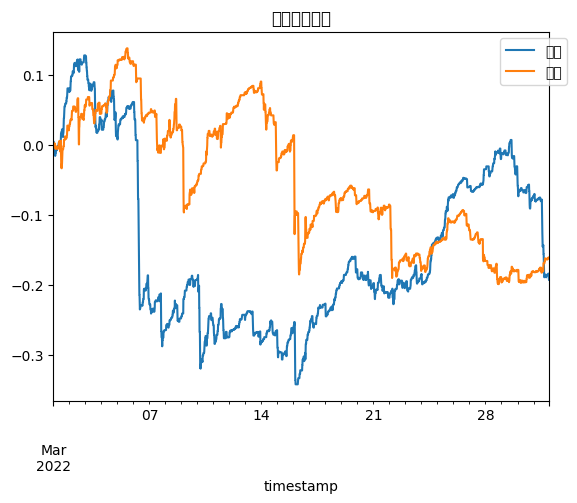

In [9]:
def calc_force_entry_price(entry_price=None, lo=None, pips=None):
    y = entry_price.copy()
    y[:] = np.nan
    force_entry_time = entry_price.copy()
    force_entry_time[:] = np.nan
    for i in range(entry_price.size):
        for j in range(i + 1, entry_price.size):
            if round(lo[j] / pips) < round(entry_price[j - 1] / pips):
                y[i] = entry_price[j - 1]
                force_entry_time[i] = j - i
                break
    return y, force_entry_time

df = pd.read_pickle('df_features.pkl')

# 呼び値 (取引所、取引ペアごとに異なるので、適切に設定してください)
pips = 1

# ATRで指値距離を計算します
limit_price_dist = df['ATR'] * 0.5
limit_price_dist = np.maximum(1, (limit_price_dist / pips).round().fillna(1)) * pips

# 終値から両側にlimit_price_distだけ離れたところに、買い指値と売り指値を出します
df['buy_price'] = df['cl'] - limit_price_dist
df['sell_price'] = df['cl'] + limit_price_dist

# Force Entry Priceの計算
df['buy_fep'], df['buy_fet'] = calc_force_entry_price(
    entry_price=df['buy_price'].values,
    lo=df['lo'].values,
    pips=pips,
)

# calc_force_entry_priceは入力と出力をマイナスにすれば売りに使えます
df['sell_fep'], df['sell_fet'] = calc_force_entry_price(
    entry_price=-df['sell_price'].values,
    lo=-df['hi'].values, # 売りのときは高値
    pips=pips,
)
df['sell_fep'] *= -1

horizon = 1 # エントリーしてからエグジットを始めるまでの待ち時間 (1以上である必要がある)
# fee = df['fee'] # maker手数料　一旦０で計算するが、richmanはdfにtimpstampに応じて変わるようにfeeを組み込んでいる。
fee = 0

# 指値が約定したかどうか (0, 1)
df['buy_executed'] = ((df['buy_price'] / pips) > (df['lo'].shift(-1) / pips)).astype('float64')
df['sell_executed'] = ((df['sell_price'] / pips) < (df['hi'].shift(-1) / pips)).astype('float64')

# yを計算
df['y_buy'] = np.where(
    df['buy_executed'],
    df['sell_fep'].shift(-horizon) / df['buy_price'] - 1 - 2 * fee,
    0
)
df['y_sell'] = np.where(
    df['sell_executed'],
    -(df['buy_fep'].shift(-horizon) / df['sell_price'] - 1) - 2 * fee,
    0
)

# バックテストで利用する取引コストを計算
df['buy_cost'] = np.where(
    df['buy_executed'],
    df['buy_price'] / df['cl'] - 1 + fee,
    0
)
df['sell_cost'] = np.where(
    df['sell_executed'],
    -(df['sell_price'] / df['cl'] - 1) + fee,
    0
)


print('毎時刻、この執行方法でトレードした場合の累積リターン')
df['y_buy'].cumsum().plot(label='買い')
df['y_sell'].cumsum().plot(label='売り')
plt.title('累積リターン')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

df.to_pickle('df_y.pkl')

In [69]:

df = df.astype(float)
df.to_pickle('df_y.pkl')

df = pd.read_pickle('df_y.pkl')

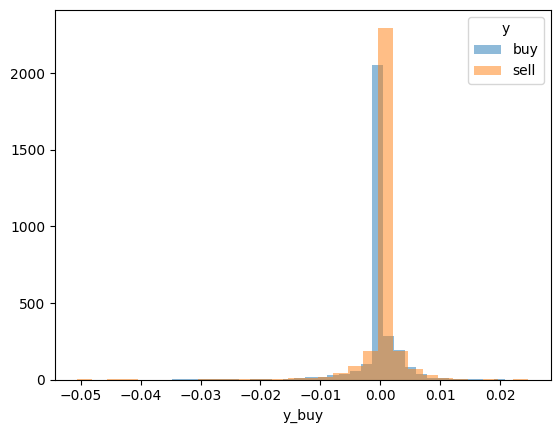

In [13]:
#y_buyとy_sellの分布を調べる。
plt.hist(df['y_buy'].dropna(), bins=30, alpha=0.5,label='buy')
plt.hist(df['y_sell'].dropna(), bins=30, alpha=0.5,label='sell')

plt.xlabel('y')
plt.legend(title='y')

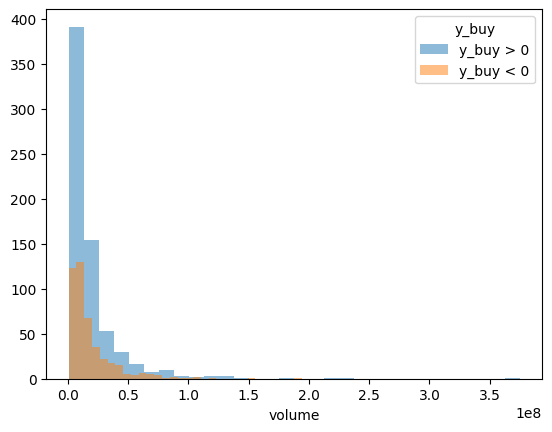

In [23]:
#volumeの分布を調べる
plt.hist(df.loc[df['y_buy'] > 0, 'volume'].dropna(), bins=30, alpha=0.5, label='y_buy > 0')
plt.hist(df.loc[df['y_buy'] < 0, 'volume'].dropna(), bins=30, alpha=0.5, label='y_buy < 0')
plt.xlabel('volume')
plt.legend(title='y_buy')

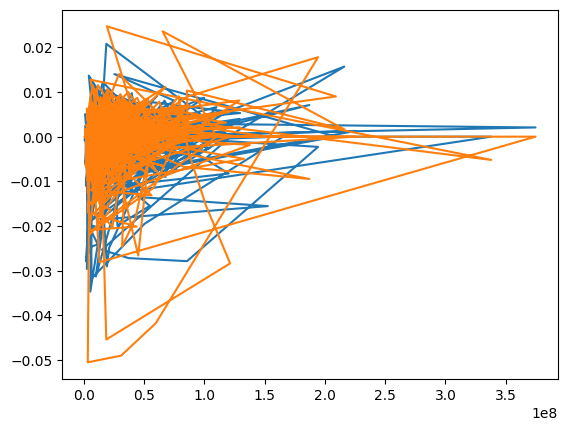

In [25]:
plt.plot(df['volume'], df['y_buy'])
plt.plot(df['volume'], df['y_sell'])


<AxesSubplot:xlabel='volume', ylabel='y_buy'>

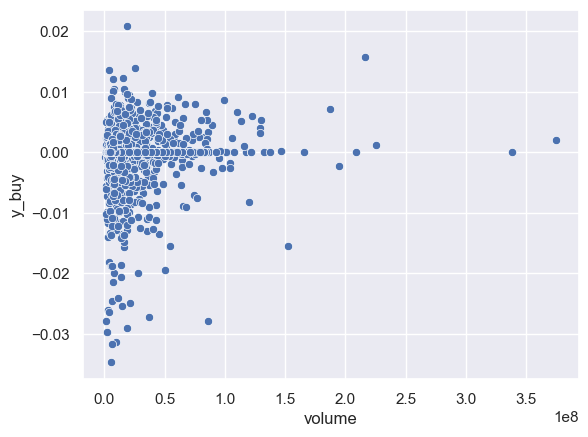

In [29]:
sns.scatterplot(x='volume', y='y_buy', data=df)

<AxesSubplot:xlabel='y_buy', ylabel='volume'>

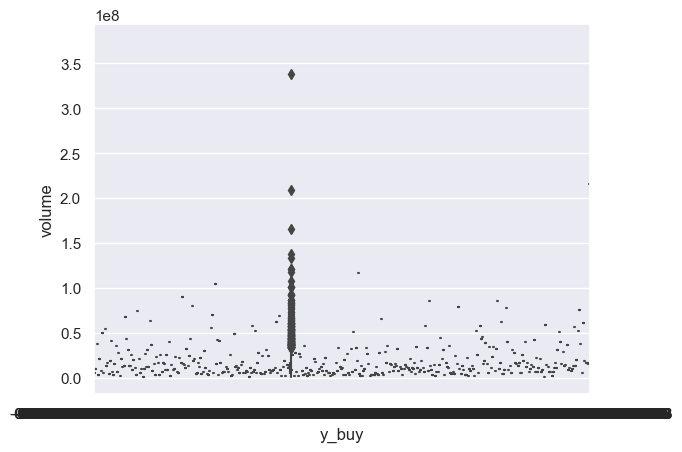

In [33]:
sns.boxplot(x='y_buy', y='volume',data=df)

### 相関係数を求める

In [58]:
df.corr()

,ADX,ADXR,APO,AROON_aroondown,AROON_aroonup,AROONOSC,BOP,CCI,DX,MACD_macd,...,HT_SINE_sine,HT_SINE_leadsine,HT_TRENDMODE,BETA,CORREL,LINEARREG_ANGLE,LINEARREG_SLOPE,STDDEV,buy_executed,sell_executed
ADX,1.000000,0.913798,0.025049,-0.047279,-0.080487,-0.019969,0.001715,0.004114,0.654098,0.025873,...,0.015247,0.008146,0.375230,-0.029628,0.052461,-0.010404,0.015209,0.130159,-0.020344,-0.042986
ADXR,0.913798,1.000000,0.006225,-0.050842,-0.063259,-0.007616,0.007059,0.026375,0.448587,0.013583,...,-0.004067,-0.015174,0.218882,-0.031999,-0.101759,0.009998,-0.000178,0.064113,-0.017019,-0.040144
APO,0.025049,0.006225,1.000000,-0.411621,0.425021,0.494320,-0.006529,0.254862,0.023004,0.903014,...,-0.141165,-0.585224,-0.008311,-0.065936,-0.003196,0.438835,0.640419,0.021480,0.010797,0.010272
AROON_aroondown,-0.047279,-0.050842,-0.411621,1.000000,-0.433275,-0.844775,-0.021176,-0.540061,0.051365,-0.428806,...,-0.259532,0.265911,-0.012843,0.050883,-0.051722,-0.676933,-0.561782,0.194603,0.006736,0.055720
AROON_aroonup,-0.080487,-0.063259,0.425021,-0.433275,1.000000,0.848304,0.019657,0.535073,0.015325,0.448647,...,0.216767,-0.312418,-0.059902,-0.112886,-0.063374,0.646712,0.569880,0.156985,0.072497,0.048027
AROONOSC,-0.019969,-0.007616,0.494320,-0.844775,0.848304,1.000000,0.024112,0.634994,-0.021079,0.518511,...,0.281280,-0.341768,-0.028021,-0.096920,-0.007193,0.781694,0.668422,-0.021124,0.039087,-0.004221
BOP,0.001715,0.007059,-0.006529,-0.021176,0.019657,0.024112,1.000000,0.276284,0.006654,0.025802,...,0.010286,0.019886,-0.014288,-0.066081,-0.017534,0.020355,0.021579,0.006271,-0.049683,0.047030
CCI,0.004114,0.026375,0.254862,-0.540061,0.535073,0.634994,0.276284,1.000000,0.003727,0.382913,...,0.403166,-0.018112,-0.041551,-0.137619,-0.021753,0.694879,0.566449,0.015656,0.011450,0.008770
DX,0.654098,0.448587,0.023004,0.051365,0.015325,-0.021079,0.006654,0.003727,1.000000,0.027321,...,0.015209,0.023682,0.393467,-0.053082,0.137566,-0.019975,0.038440,0.305364,0.030485,0.030822
MACD_macd,0.025873,0.013583,0.903014,-0.428806,0.448647,0.518511,0.025802,0.382913,0.027321,1.000000,...,-0.043970,-0.481948,-0.014684,-0.086089,0.010491,0.494600,0.729420,0.047722,0.003194,0.022394


<AxesSubplot:>

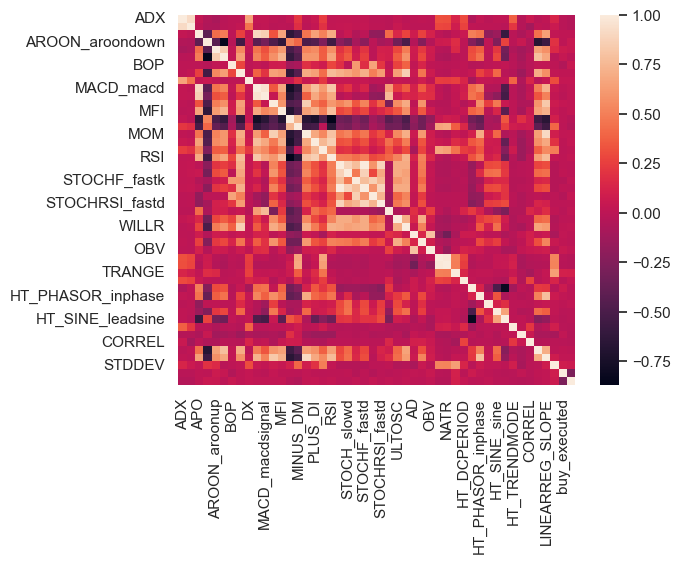

In [57]:
sns.heatmap(df.corr())

Text(0.5, 1.0, 'relation with y_buy')

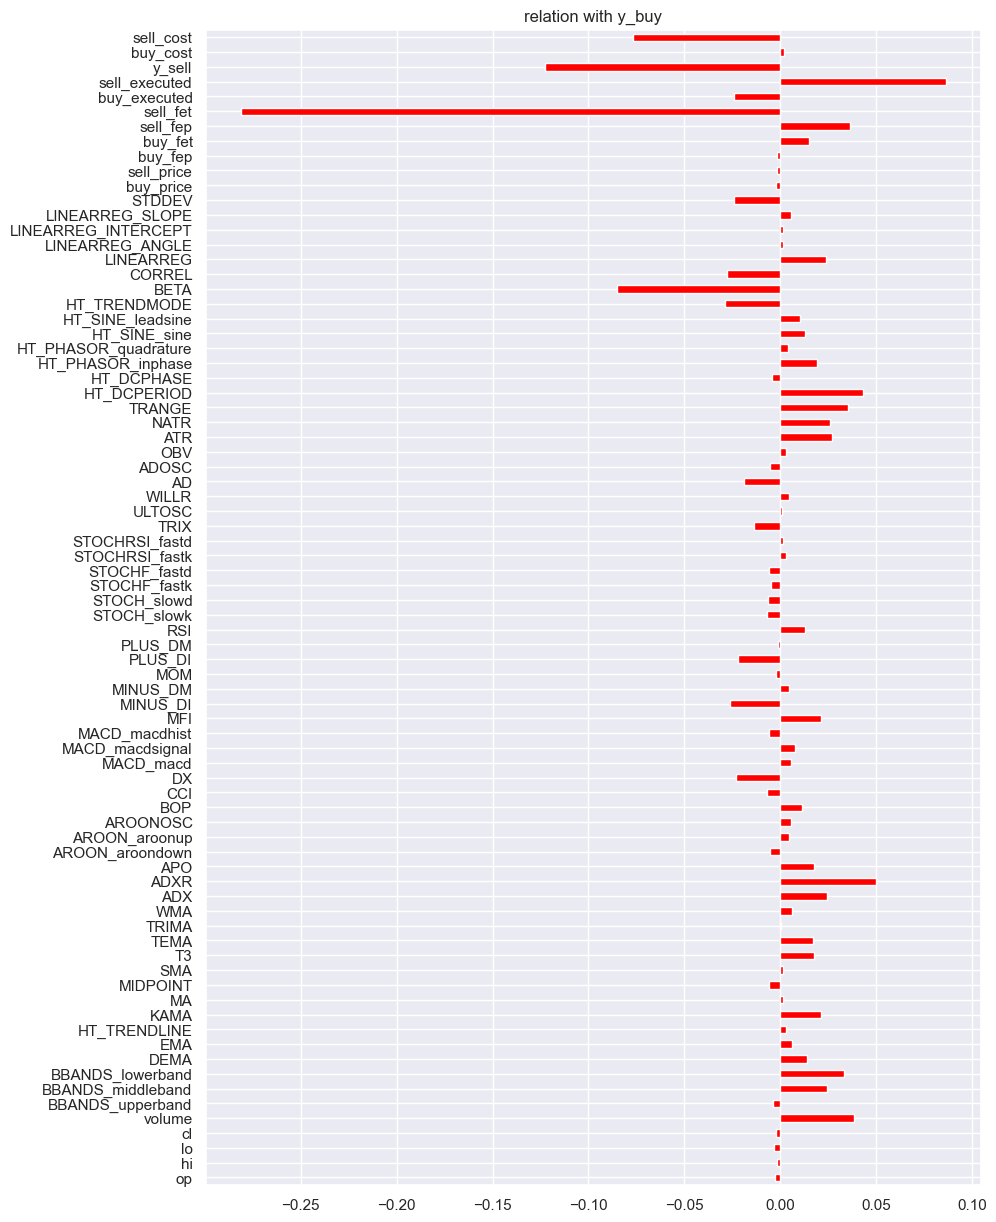

In [72]:
y = df['y_buy']
df_1 = df.drop(['y_buy'], axis=1)

df_corr = df_1.corrwith(y)

plt.figure(figsize=(10, 15))
df_corr.plot.barh(color='red')
plt.title('relation with y_buy')


Text(0.5, 1.0, 'relation with y_sell')

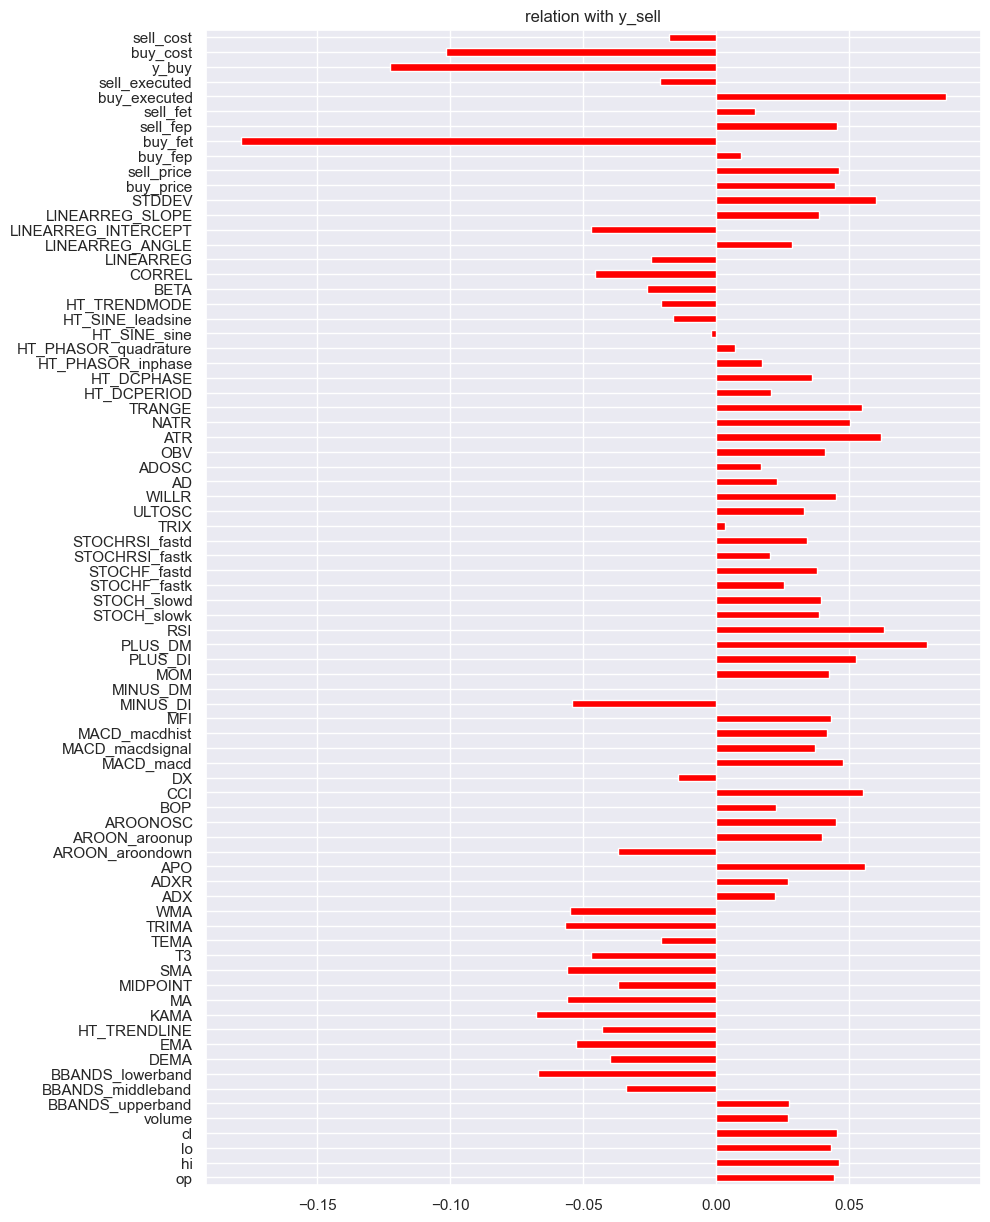

In [73]:
y = df['y_sell']
df_1 = df.drop(['y_sell'], axis=1)

df_corr = df_1.corrwith(y)

plt.figure(figsize=(10, 15))
df_corr.plot.barh(color='red')
plt.title('relation with y_sell')

In [74]:
df_corr

op               0.044373
hi               0.046108
lo               0.043284
cl               0.045405
volume           0.027013
                   ...   
buy_executed     0.086348
sell_executed   -0.021195
y_buy           -0.122699
buy_cost        -0.101669
sell_cost       -0.017573
Length: 78, dtype: float64